In [0]:
from google.colab import drive
drive.mount('/content/drive')
! mkdir data
! cp -r "drive/My Drive/dul" data

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import numpy as np
import torch
import torch.utils.data
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
import pickle
import torch.nn.functional as F
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
def draw_losses(train_losses, test_losses):
    plt.plot(list(range(len(train_losses))), train_losses, color='r', label='train')
    plt.plot(list(range(len(test_losses))), test_losses, color='b', label='test')
    plt.legend()
    plt.show()

In [0]:
def p(theta, X):
    return torch.exp(theta[X]) / torch.sum(torch.exp(theta))
def L(output):
    return -(torch.log(output)).mean()

# №1

In [0]:
def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [0]:
class ProbModel:
    def __init__(self, size=200):
        self.theta = torch.zeros(size, requires_grad=True)
        
    def forward(self, X):
        return p(self.theta, X)
    
    def parameters(self):
        return [self.theta]
    
    def __call__(self, X):
        return self.forward(X)

In [0]:
X = torch.tensor(sample_data(), dtype=torch.long)
X_train = X[:8000]
X_test = X[8000:]
dataset = torch.utils.data.DataLoader(X_train, batch_size=1000, shuffle=True)

In [0]:
prob_model = ProbModel()
optimizer = torch.optim.SGD(params=prob_model.parameters(), lr=0.03)

In [0]:
train_losses = []
test_losses = []
n_epochs = 20
for epoch in range(n_epochs):
    train_loss = 0
    for X1 in dataset:
        optimizer.zero_grad()
        output = prob_model(X1)
        loss = L(output)
        train_loss += loss.double()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss / 8000)
    test_loss = L(prob_model(X_test)).double() / 2000
    test_losses.append(test_loss)

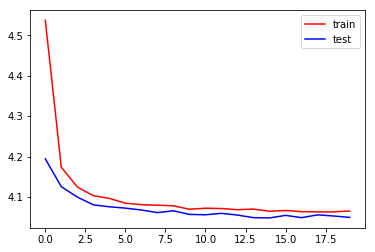

In [0]:
draw_losses(train_losses, test_losses)

In [0]:
predicted_probs = prob_model(np.arange(100)).tolist()
empirical_probs = np.zeros(100)
for x in X[8000:9000]:
    empirical_probs[x] += 1
empirical_probs /= 1000

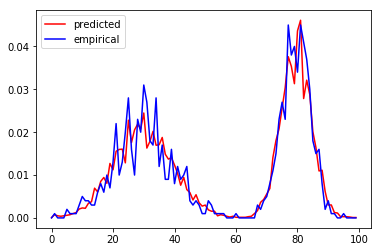

In [0]:
plt.plot(list(range(100)), predicted_probs, color='r', label='predicted')
plt.plot(list(range(100)), empirical_probs, color='b', label='empirical')
plt.legend()
plt.show()

# №2

In [0]:
distribution = np.load('data/dul/distribution.npy')
indexes = np.array([[(i, j) for j in range(200)] for i in range(200)]).reshape(200 * 200, 2)
X = indexes[np.random.choice(np.arange(200 * 200), 100_000, p=distribution.reshape(-1))]
X_train, X_test = X[:80_000], X[80_000:]

# №2a

In [0]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(200, 200),
            nn.Softmax()
        )
        
    def forward(self, x):
        return self.layers(x)

class ProbModel2D:
    def __init__(self):
        self.prob_model = ProbModel(200)
        self.mlp = MLP()
        self.one_hot_vocab = torch.eye(200)
        
    def forward(self, X):
        X1, X2 = X[:,0], X[:,1]
        probs1 = self.prob_model(X1)
        distr2 = self.mlp(self.one_hot_vocab[X1])
        probs2 = distr2[np.arange(X.shape[0]),X2]
        probs = probs1 * probs2
        return probs
    
    def parameters(self):
        return list(self.mlp.parameters()) + self.prob_model.parameters()
    
    def __call__(self, X):
        return self.forward(X)

In [0]:
prob_model_2d = ProbModel2D()
dataset = torch.utils.data.DataLoader(X_train, batch_size=1000, shuffle=True)
#optimizer = torch.optim.SGD(params=prob_model_2d.parameters(), lr=0.01)
optimizer = torch.optim.Adam(params=prob_model_2d.parameters())

In [0]:
train_losses = []
test_losses = []
n_epochs = 8
for epoch in tqdm(range(n_epochs)):
    for X_batch in dataset:
        optimizer.zero_grad()
        
        probs = prob_model_2d(X_batch)
        
        loss = L(probs) / len(probs)
        train_loss = loss.double()
        loss.backward()
        optimizer.step()
        
        train_losses.append(train_loss)
        test_loss = L(prob_model_2d(X_test)).double() / len(X_test)
        test_losses.append(test_loss)
    #print(f"Epoch #{epoch}, train loss = {train_loss}, test loss = {test_loss}")

/Users/aleksandr.fedotov/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


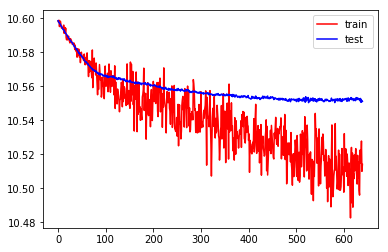

In [0]:
draw_losses(train_losses, test_losses)

In [0]:
x1_distrib = prob_model_2d.prob_model(np.arange(200)).detach().numpy()
one_hot_guys = torch.eye(200)
x2_distrib = np.array([prob_model_2d.mlp(one_hot_guys[i]).tolist() for i in range(200)])
predicted_distrib = (x2_distrib.T * x1_distrib).T
predicted_distrib /= np.sum(predicted_distrib)

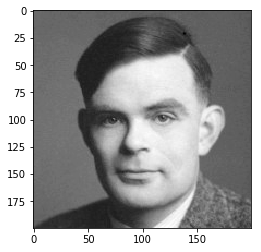

In [0]:
plt.imshow(distribution, cmap='gray')
plt.show()

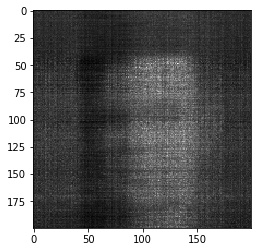

In [0]:
plt.imshow(predicted_distrib, cmap='gray')
plt.show()

# №2b

In [0]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, ms, bias=True):
        super().__init__(in_features, out_features, bias)
        m1, m2 = ms
        mask = m2.reshape(-1, 1) >= m1.reshape(1, -1)
        
        mask = mask.astype(np.float32)
        self.register_buffer('mask', torch.tensor(mask))
        
    def forward(self, x):
        return F.linear(x, self.mask * self.weight, self.bias)

class MADE(nn.Module):
    def __init__(self, d=2, n=200, hidden_sizes=[200, 200]):
        super(MADE, self).__init__()
        
        self.d = d
        self.n = n
        input_size = self.d * self.n
        
        m = [np.repeat(np.arange(self.d), self.n) + 1]
        for layer_size in hidden_sizes:
            m += [np.random.randint(m[-1].min(), d, size=layer_size)]
        
        layers = [
            MaskedLinear(input_size, hidden_sizes[0], m[0:2]),
            nn.ReLU()
        ]
        for i in np.arange(1, len(hidden_sizes)):
            layers += [
                MaskedLinear(hidden_sizes[i-1], hidden_sizes[i], m[i:i + 2]),
                nn.ReLU()
            ]
        
        layers += [
            MaskedLinear(hidden_sizes[-1], input_size, (m[-1], m[0]))
        ]
        self.layers = nn.Sequential(*layers)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        x_in = x
        
        x = x.view(-1, self.d * self.n)
        x = self.layers(x)
        x = x.view(-1, self.d, self.n)
        x = self.softmax(x)
        
        x = (x * x_in).sum(dim=2)
        return x

In [0]:
made = MADE(2, 200, [200, 200])
dataset = torch.utils.data.DataLoader(X_train, batch_size=1000, shuffle=True)
#optimizer = torch.optim.SGD(params=made.parameters(), lr=0.01)
optimizer = torch.optim.Adam(params=made.parameters())

In [0]:
train_losses = []
test_losses = []
n_epochs = 5
one_hot_guys = torch.eye(200)

def to_one_hots(X_b):
    return torch.cat((one_hot_guys[X_b[:,0]], one_hot_guys[X_b[:,1]]), 1).reshape(len(X_b), 2, 200)

for epoch in tqdm(range(n_epochs)):
    for X_batch in dataset:
        optimizer.zero_grad()
        X_batch = to_one_hots(X_batch)
        probs = made(X_batch)
        probs = probs[:,0] * probs[:,1]
        loss = L(probs)
        train_loss = loss.double()
        loss.backward()
        optimizer.step()
        
        train_loss /= 1000
        train_losses.append(train_loss)
        probs_test = made(to_one_hots(torch.tensor(X_test)))
        test_loss = L(probs_test[:,0] * probs_test[:,1]).double() / 20000
        test_losses.append(test_loss)
    #print(f"Epoch #{epoch}, train loss = {train_loss}, test loss = {test_loss}")

In [0]:
X_batch.shape

torch.Size([1000, 2, 200])

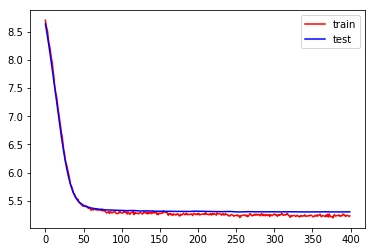

In [0]:
draw_losses(train_losses, test_losses)

In [0]:
with torch.no_grad():
    predicted_distrib_made = torch.zeros((200, 200))
    for i in tqdm(range(200)):
        for j in range(200):
            vi = F.one_hot(torch.tensor([i]), 200).float()
            vj = F.one_hot(torch.tensor([j]), 200).float()
            prob = made(torch.cat((vi, vj)))
            predicted_distrib_made[i][j] = prob[0][0] * prob[0][1]

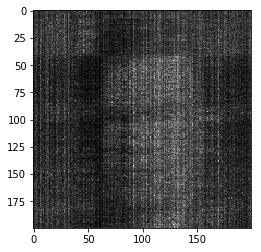

In [0]:
plt.imshow(predicted_distrib_made, cmap='gray')
plt.show()

# №3

In [0]:
with open('data/dul/mnist-hw1.pkl', 'rb') as file:
    mnist = pickle.load(file)

In [0]:
mnist_train, mnist_test = torch.tensor(mnist['train']), torch.tensor(mnist['test'])

In [0]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        assert mask_type in {'A', 'B'}
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

In [0]:
class PixelCNN(nn.Module):
    def __init__(self, fm=28):
        super(PixelCNN, self).__init__()
        
        layers = [MaskedConv2d('A', 3,  fm, 7, 1, 3, bias=False),
                  nn.BatchNorm2d(fm), nn.ReLU(True)]
        for i in range(7):
            layers += [MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True)]
        layers += [nn.Conv2d(fm, 3 * 4, 1), nn.Softmax(dim=-1)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        n, c, h, w = x.shape
        x = self.layers(x.float())
        x = x.reshape(n, c, 4, h, w)
        x = x.permute(0, 3, 4, 1, 2)
        return x

# №3a

In [0]:
pixelCnn = PixelCNN().to(device)
dataset_mnist = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
optimizer = torch.optim.Adam(params=pixelCnn.parameters())

In [0]:
train_losses = []
test_losses = []
n_epochs = 5
for epoch in tqdm(range(n_epochs)):
    for X_batch in tqdm(dataset_mnist):
        X_batch = X_batch.to(device)
        optimizer.zero_grad()
        distrib = pixelCnn(X_batch)
        real = F.one_hot(X_batch.long(), 4).float()
        probs = (real * distrib).sum(dim=-1)
        loss = L(probs)
        train_loss = loss.item()
        loss.backward()
        optimizer.step()
        
        train_losses.append(train_loss)
        with torch.no_grad():
          real_test = F.one_hot(mnist_test[:50].long()).float().to(device)
          distrib_test = pixelCnn(mnist_test[:50].to(device))
          test_loss = L((real_test * distrib_test).sum(dim=-1)).item()
          test_losses.append(test_loss)

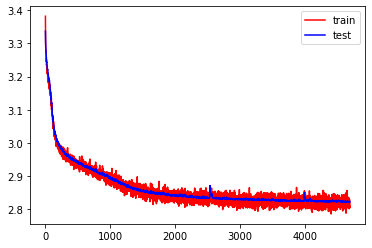

In [0]:
draw_losses(train_losses, test_losses)

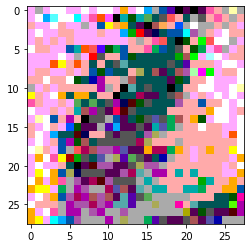

In [0]:
image = np.zeros((1, 28, 28, 3), dtype=np.uint8)
with torch.no_grad():
  for x in tqdm(range(28)):
      for y in range(28):
          for c in range(3):
              image_tensor = torch.LongTensor(image).to(device)
              probs = pixelCnn(image_tensor).cpu().numpy()
              image[0, x, y, c] = np.random.choice(
                      4, p=ps[0, x, y, c] / sum(ps[0, x, y, c]))
                  
image *= 85

plt.imshow(image[0])
plt.show()